           In         Out Direction    CallDate         CallTime  DOW  \
0  4638472273  2666307251  Incoming  2010-12-25  07:16:24.736813  Sat   
1  4638472273  1755442610  Incoming  2010-12-25  21:18:30.053710  Sat   
2  4638472273  5481755331  Incoming  2010-12-25  14:52:42.878016  Sat   
3  4638472273  1755442610  Incoming  2010-12-25  16:02:09.001913  Sat   
4  4638472273  2145623768  Incoming  2010-12-25  15:28:35.028554  Sat   

         Duration                               TowerID   TowerLat   TowerLon  
0  0:02:41.741499  0db53dd3-eb9c-4344-abc5-c2d74ebc3eec  32.731611 -96.709417  
1  0:02:47.108750  aeaf8b43-8034-44fe-833d-31854a75acbf  32.731722 -96.709500  
2  0:04:35.356341  fadaa83f-6001-45fd-aa4a-17d6c6b7ec00  32.899944 -96.910389  
3  0:02:23.498499  fadaa83f-6001-45fd-aa4a-17d6c6b7ec00  32.899944 -96.910389  
4  0:03:54.692497  95d7920d-c3cd-4d20-a568-9a55800dc807  32.899944 -96.910389  
Empty DataFrame
Columns: [In, Out, Direction, CallDate, CallTime, DOW, Duration, 

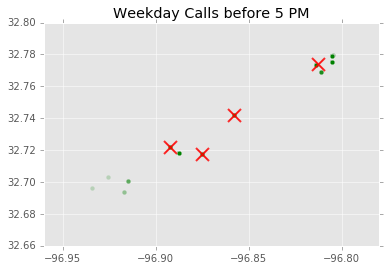

In [1]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib
from sklearn.cluster import KMeans
%matplotlib inline
matplotlib.style.use('ggplot') # Look Pretty

#
# INFO: This dataset has call records for 10 users tracked over the course of 3 years.
# Your job is to find out where the users likely live at!



def showandtell(title=None):
  if title != None: plt.savefig(title + ".png", bbox_inches='tight', dpi=300)
  plt.show()
  exit()

def clusterInfo(model):
  print "Cluster Analysis Inertia: ", model.inertia_
  print '------------------------------------------'
  for i in range(len(model.cluster_centers_)):
    print "\n  Cluster ", i
    print "    Centroid ", model.cluster_centers_[i]
    print "    #Samples ", (model.labels_==i).sum() # NumPy Power

# Find the cluster with the least # attached nodes
def clusterWithFewestSamples(model):
  # Ensure there's at least on cluster...
  minSamples = len(model.labels_)
  minCluster = 0
  for i in range(len(model.cluster_centers_)):
    if minSamples > (model.labels_==i).sum():
      minCluster = i
      minSamples = (model.labels_==i).sum()
  print "\n  Cluster With Fewest Samples: ", minCluster
  return (model.labels_==minCluster)


def doKMeans(data, clusters=0):  
  #
  # TODO: Be sure to only feed in Lat and Lon coordinates to the KMeans algo, since none of the other
  # data is suitable for your purposes. Since both Lat and Lon are (approximately) on the same scale,
  # no feature scaling is required. Print out the centroid locations and add them onto your scatter
  # plot. Use a distinguishable marker and color.
  #
  # Hint: Make sure you fit ONLY the coordinates, and in the CORRECT order (lat first).
  # This is part of your domain expertise.
  #
  # .. your code here ..
  df1 = pd.concat([data.TowerLon, data.TowerLat], axis = 1)
  kmeans = KMeans(n_clusters = clusters)
  labels = kmeans.fit(df1)
  centroids = kmeans.cluster_centers_
  ax.scatter(x = centroids[:,0], y = centroids[:,1], c= "r", marker = "x", s = 100)
  model = kmeans
  return model



#
# TODO: Load up the dataset and take a peek at its head and dtypes.
# Convert the date using pd.to_datetime, and the time using pd.to_timedelta
#
# .. your code here ..
df = pd.read_csv("datasets/CDR.csv")
print df.head()
df.CallDate = pd.to_datetime(df.CallDate)
df.Durtation = pd.to_timedelta(df.Duration)
df.CallTime = pd.to_timedelta(df.CallTime)
print df[(df.TowerLat == 32.721986) & (df.TowerLat == -96.890587)] # the data for second question (Post office lon/Lat)


#
# TODO: Get a distinct list of "In" phone numbers (users) and store the values in a
# regular python list.
# Hint: https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.tolist.html
#
# .. your code here ..

users = df.In.unique()
print users

#
# INFO: The locations map above should be too "busy" to really wrap your head around. This
# is where domain expertise comes into play. Your intuition tells you that people are likely
# to behave differently on weekends:
#
# On Weekdays:
#   1. People probably don't go into work
#   2. They probably sleep in late on Saturday
#   3. They probably run a bunch of random errands, since they couldn't during the week
#   4. They should be home, at least during the very late hours, e.g. 1-4 AM
#
# On Weekdays:
#   1. People probably are at work during normal working hours
#   2. They probably are at home in the early morning and during the late night
#   3. They probably spend time commuting between work and home everyday

print "\n\nExamining person: ", 8

# 
# TODO: Create a slice called user1 that filters to only include dataset records where the
# "In" feature (user phone number) is equal to the first number on your unique list above
#
# .. your code here ..
user1 = df[(df.In == users[8])]

#
# TODO: Alter your slice so that it includes only Weekday (Mon-Fri) values.
#
# .. your code here ..
user1 = user1[(user1.DOW == 'Mon') | (user1.DOW == 'Tue') | (user1.DOW == 'Wed') | (user1.DOW == 'Thu') | (user1.DOW == 'Fri')]


#
# TODO: The idea is that the call was placed before 5pm. From Midnight-730a, the user is
# probably sleeping and won't call / wake up to take a call. There should be a brief time
# in the morning during their commute to work, then they'll spend the entire day at work.
# So the assumption is that most of the time is spent either at work, or in 2nd, at home.
#
# .. your code here ..
user1 = user1[(user1.CallTime < '17:00:00')]


#
# TODO: Plot the Cell Towers the user connected to
#
# .. your code here ..
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(user1.TowerLon, user1.TowerLat, c='g', marker='o', alpha = 0.2)
ax.set_title('Weekday Calls before 5 PM')
#
# INFO: Run K-Means with K=3 or K=4. There really should only be a two areas of concentration. If you
# notice multiple areas that are "hot" (multiple areas the usr spends a lot of time at that are FAR
# apart from one another), then increase K=5, with the goal being that all centroids except two will
# sweep up the annoying outliers and not-home, not-work travel occasions. the other two will zero in
# on the user's approximate home location and work locations. Or rather the location of the cell
# tower closest to them.....
model = doKMeans(user1, 4)


#
# INFO: Print out the mean CallTime value for the samples belonging to the cluster with the LEAST
# samples attached to it. If our logic is correct, the cluster with the MOST samples will be work.
# The cluster with the 2nd most samples will be home. And the K=3 cluster with the least samples
# should be somewhere in between the two. What time, on average, is the user in between home and
# work, between the midnight and 5pm?
midWayClusterIndices = clusterWithFewestSamples(model)
midWaySamples = user1[midWayClusterIndices]
print "    Its Waypoint Time: ", midWaySamples.CallTime.mean()

#
# Let's visualize the results!
# First draw the X's for the clusters:
ax.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=169, c='r', marker='x', alpha=0.8, linewidths=2)
#
# Then save the results:
showandtell('Weekday Calls Centroids')  # Comment this line out when you're ready to proceed